# Lexicon-Based vs Embedding-Based Moral Scoring - Kannada Texts

This notebook compares two approaches for moral foundation scoring across **Kannada texts**:
1. **Lexicon-Based**: Simple word-counting from Kannada MFD
2. **Embedding-Based**: Semantic similarity using IndicSBERT (from Step3)

## Texts Analyzed:
- Janapada Kathegalu (Folk Tales)
- Neeti Kathegalu (Moral Stories)

## Goal:
Evaluate which method better captures moral content in Kannada literary texts.

In [24]:
!pip install matplotlib pandas seaborn scipy 

In [25]:
!pip install scikit-learn

In [26]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from scipy.stats import spearmanr, pearsonr
from sklearn.metrics import cohen_kappa_score
import os
import glob
import re

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)

# Suppress warnings
# import warnings
# warnings.filterwarnings('ignore')

## 1. Load Kannada MFD Dictionary

In [27]:
# Load Kannada MFD
with open('kannada_mfd.pkl', 'rb') as f:
    kannada_mfd = pickle.load(f)

print("Kannada MFD Loaded:")
for foundation, words in kannada_mfd.items():
    print(f"  {foundation}: {len(words)} words")

# Show sample words
print("\nSample words from care.virtue:")
print(kannada_mfd['care.virtue'][:5])

moral_foundations = list(kannada_mfd.keys())
print(f"\nTotal foundations: {len(moral_foundations)}")

Kannada MFD Loaded:
  care.virtue: 182 words
  care.vice: 288 words
  fairness.virtue: 115 words
  fairness.vice: 236 words
  loyalty.virtue: 143 words
  loyalty.vice: 49 words
  authority.virtue: 301 words
  authority.vice: 130 words
  sanctity.virtue: 272 words
  sanctity.vice: 388 words

Sample words from care.virtue:
['ಕರುಣೆ', 'ಸಹಾನುಭೂತಿ', 'ದಯೆ', 'ಕಾಳಜಿ', 'ಉದಾರತೆ']

Total foundations: 10


## 2. Load All Kannada Texts and Embedding Results

In [28]:
# Get all CSV files from kannada-pre-processed folder
csv_files = glob.glob('kannada-pre-processed/*.csv')
csv_files.sort()

print("Found CSV files:")
for f in csv_files:
    print(f"  - {os.path.basename(f)}")

# Dictionary to store all data
texts_data = {}
embedding_data = {}

# Load each text
for csv_file in csv_files:
    basename = os.path.basename(csv_file).replace('.csv', '')
    
    # Load original text
    df = pd.read_csv(csv_file)
    texts_data[basename] = df
    
    # Load corresponding embedding results from phase3_outputs
    embedding_file = f'phase3_outputs/{basename}_moral_scores.csv'
    if os.path.exists(embedding_file):
        embedding_df = pd.read_csv(embedding_file)
        embedding_data[basename] = embedding_df
        print(f"\n✓ {basename}: {len(df)} paragraphs loaded with embedding results")
    else:
        print(f"\n⚠ {basename}: {len(df)} paragraphs loaded (NO embedding results found)")

print(f"\nTotal texts loaded: {len(texts_data)}")
print(f"Total with embedding results: {len(embedding_data)}")

Found CSV files:
  - 1-janapada-kathegalu.csv
  - 2-neeti-kathegalu.csv

✓ 1-janapada-kathegalu: 220 paragraphs loaded with embedding results

✓ 2-neeti-kathegalu: 216 paragraphs loaded with embedding results

Total texts loaded: 2
Total with embedding results: 2


## 3. Implement Lexicon-Based Scoring

### Method:
For each text:
1. Tokenize (split into Kannada words)
2. Count matches with each moral foundation in Kannada MFD
3. Calculate normalized scores (matches / total words)
4. Identify dominant moral (highest score)

In [29]:
def tokenize_kannada(text):
    """
    Simple Kannada tokenization - split by whitespace and punctuation.
    Kannada Unicode range: U+0C80 to U+0CFF
    """
    # Remove punctuation and split
    tokens = re.findall(r'[\u0C80-\u0CFF]+', str(text))
    return tokens

def lexicon_score_text(text, mfd_dict):
    """
    Score a text using lexicon-based approach.
    
    Returns:
    - raw_counts: dict of {foundation: count}
    - normalized_scores: dict of {foundation: count/total_words}
    - dominant_moral: foundation with highest count
    - dominant_score: count of dominant moral
    """
    tokens = tokenize_kannada(text)
    total_words = len(tokens)
    
    # Count matches for each foundation
    raw_counts = {foundation: 0 for foundation in mfd_dict.keys()}
    
    for token in tokens:
        for foundation, word_list in mfd_dict.items():
            if token in word_list:
                raw_counts[foundation] += 1
    
    # Normalize by total words (TF normalization)
    normalized_scores = {
        foundation: count / total_words if total_words > 0 else 0
        for foundation, count in raw_counts.items()
    }
    
    # Dominant moral
    if sum(raw_counts.values()) > 0:
        dominant_moral = max(raw_counts, key=raw_counts.get)
        dominant_score = raw_counts[dominant_moral]
    else:
        dominant_moral = None
        dominant_score = 0
    
    return raw_counts, normalized_scores, dominant_moral, dominant_score

# Test on sample
sample_text = list(texts_data.values())[0]['cleaned_text'].iloc[0]
raw, norm, dom, score = lexicon_score_text(sample_text, kannada_mfd)
print(f"Sample text: {sample_text[:100]}...")
print(f"\nDominant moral: {dom} (score: {score})")
print(f"Non-zero foundations: {[k for k, v in raw.items() if v > 0]}")

Sample text: ೧. ಮುತುಗದ ಎಲೆ ಗೋತಾಯಿ
ಒಂದ್‌ ಪಟ್ಟಣ. ಒಬ್ಬ ದೊಡ್ಡ ದೊರೆ. ದೊಡ್ಡ ದೊರೆಗೆ ಏಳ್‌ ಮಕ್ಕಳು.
ಏಳ್‌ ಮಕ್ಕಳಿಗೂ ಚೆನ್ನಾಗಿ ...

Dominant moral: authority.virtue (score: 2)
Non-zero foundations: ['care.vice', 'authority.virtue', 'sanctity.virtue']


## 4. Apply Lexicon-Based Scoring to All Texts

In [30]:
# Dictionary to store lexicon results
lexicon_results = {}

print("="*70)
print("PROCESSING ALL TEXTS WITH LEXICON-BASED APPROACH")
print("="*70)

for text_name, df in texts_data.items():
    print(f"\nProcessing {text_name}...")
    
    # Use cleaned_text column
    text_column = 'cleaned_text'
    print(f"  Using column: '{text_column}'")
    
    results = []
    for idx, row in df.iterrows():
        text = row[text_column]
        raw, norm, dom, score = lexicon_score_text(text, kannada_mfd)
        
        result = {'paragraph_num': row.get('paragraph_num', idx + 1)}
        result['text'] = text[:200] + '...' if len(str(text)) > 200 else text  # Truncate for storage
        result.update(norm)  # Add normalized scores
        result['dominant_moral_lexicon'] = dom
        result['dominant_score_lexicon'] = score
        results.append(result)
    
    lexicon_results[text_name] = pd.DataFrame(results)
    
    # Calculate coverage
    no_matches = lexicon_results[text_name]['dominant_moral_lexicon'].isna().sum()
    coverage = (1 - no_matches / len(results)) * 100
    
    print(f"Processed {len(results)} paragraphs")
    print(f" Coverage: {coverage:.1f}% ({len(results)-no_matches}/{len(results)} paragraphs with MFD matches)")

# print(lexicon_results['1-janapada-kathegalu']['text'], lexicon_results['1-janapada-kathegalu']['dominant_moral_lexicon'])
print(lexicon_results['1-janapada-kathegalu'][['paragraph_num', 'dominant_moral_lexicon', 'dominant_score_lexicon']].head(20))
print("\n" + "="*70)
print(f"TOTAL PARAGRAPHS PROCESSED: {sum(len(df) for df in lexicon_results.values())}")
print("="*70)

PROCESSING ALL TEXTS WITH LEXICON-BASED APPROACH

Processing 1-janapada-kathegalu...
  Using column: 'cleaned_text'
Processed 220 paragraphs
 Coverage: 95.0% (209/220 paragraphs with MFD matches)

Processing 2-neeti-kathegalu...
  Using column: 'cleaned_text'
Processed 216 paragraphs
 Coverage: 88.4% (191/216 paragraphs with MFD matches)
    paragraph_num dominant_moral_lexicon  dominant_score_lexicon
0               1       authority.virtue                       2
1               2       authority.virtue                       2
2               3            care.virtue                       2
3               4            care.virtue                       1
4               5            care.virtue                       4
5               6       authority.virtue                       3
6               7            care.virtue                       2
7               8        sanctity.virtue                       3
8               9       authority.virtue                       3
9         

## 5. Compare Lexicon vs Embedding Results for Each Text

In [31]:
# Dictionary to store comparison results
comparison_results = {}

print("="*70)
print("COMPARING LEXICON VS EMBEDDING RESULTS")
print("="*70)

for text_name in lexicon_results.keys():
    # Map lexicon text names to embedding file names
    embedding_key = None
    for key in embedding_data.keys():
        if text_name.replace('-', '_') in key.replace('-', '_') or key.replace('-', '_') in text_name.replace('-', '_'):
            embedding_key = key
            break
    
    if embedding_key is None:
        print(f"\n {text_name}: No embedding data available, skipping comparison")
        continue
    
    print(f"\n--- {text_name.upper()} ---")
    
    lex_df = lexicon_results[text_name]
    emb_df = embedding_data[embedding_key]
    
    # Create comparison dataframe
    compare_df = pd.DataFrame({
        'paragraph_num': lex_df['paragraph_num'],
        'dominant_lexicon': lex_df['dominant_moral_lexicon'],
        'dominant_embedding': emb_df['dominant_moral'] if 'dominant_moral' in emb_df.columns else None
    })
    
    comparison_results[text_name] = compare_df
    
    # Calculate statistics
    total = len(compare_df)
    with_matches = compare_df['dominant_lexicon'].notna().sum()
    coverage_pct = with_matches / total * 100
    
    print(f"  Total paragraphs: {total}")
    print(f"  Paragraphs with lexicon matches: {with_matches} ({coverage_pct:.1f}%)")
    
    if with_matches > 0:
        compare_clean = compare_df.dropna()
        agreement = (compare_clean['dominant_lexicon'] == compare_clean['dominant_embedding']).sum()
        agreement_pct = agreement / len(compare_clean) * 100 if len(compare_clean) > 0 else 0
        
        print(f"  Exact agreement: {agreement}/{len(compare_clean)} ({agreement_pct:.1f}%)")
        
        # Cohen's Kappa
        if len(compare_clean) > 1:
            try:
                kappa = cohen_kappa_score(compare_clean['dominant_lexicon'], 
                                         compare_clean['dominant_embedding'])
                print(f"  Cohen's Kappa: {kappa:.3f}", end="")
                if kappa > 0.6:
                    print(" (Substantial agreement)")
                elif kappa > 0.4:
                    print(" (Moderate agreement)")
                else:
                    print(" (Fair/slight agreement)")
            except:
                print("  Cohen's Kappa: N/A")

print("\n" + "="*70)

COMPARING LEXICON VS EMBEDDING RESULTS

--- 1-JANAPADA-KATHEGALU ---
  Total paragraphs: 220
  Paragraphs with lexicon matches: 209 (95.0%)
  Exact agreement: 43/209 (20.6%)
  Cohen's Kappa: -0.010 (Fair/slight agreement)

--- 2-NEETI-KATHEGALU ---
  Total paragraphs: 216
  Paragraphs with lexicon matches: 191 (88.4%)
  Exact agreement: 47/191 (24.6%)
  Cohen's Kappa: 0.108 (Fair/slight agreement)



## Debug Start

In [33]:
# DEBUG: Check paragraph alignment between lexicon and embedding results
print("="*70)
print("CHECKING PARAGRAPH ALIGNMENT")
print("="*70)

for text_name in lexicon_results.keys():
    embedding_key = text_name  # They should have the same key
    
    if embedding_key not in embedding_data:
        print(f"\n⚠ {text_name}: No embedding data found")
        continue
    
    lex_df = lexicon_results[text_name]
    emb_df = embedding_data[embedding_key]
    
    print(f"\n--- {text_name} ---")
    print(f"  Lexicon rows: {len(lex_df)}, Embedding rows: {len(emb_df)}")
    
    # Check if paragraph_num column exists and matches
    lex_para_col = 'paragraph_num' if 'paragraph_num' in lex_df.columns else None
    emb_para_col = 'para_number' if 'para_number' in emb_df.columns else ('paragraph_num' if 'paragraph_num' in emb_df.columns else None)
    
    print(f"  Lexicon para column: {lex_para_col}, Embedding para column: {emb_para_col}")
    print(f"  Embedding columns: {list(emb_df.columns)}")
    
    if lex_para_col and emb_para_col:
        lex_paras = lex_df[lex_para_col].tolist()
        emb_paras = emb_df[emb_para_col].tolist()
        
        # Check first 5 paragraphs
        print(f"  First 5 lexicon para_nums: {lex_paras[:5]}")
        print(f"  First 5 embedding para_nums: {emb_paras[:5]}")
        
        # Check if they match
        if lex_paras == emb_paras:
            print(f"  ✓ Paragraph numbers MATCH perfectly")
        else:
            mismatches = sum(1 for l, e in zip(lex_paras, emb_paras) if l != e)
            print(f"  ⚠ MISMATCH: {mismatches} paragraphs don't align!")
    
    # Show sample comparison with actual text
    print(f"\n  Sample comparison (para 1):")
    print(f"    Lexicon dominant: {lex_df.iloc[0].get('dominant_moral_lexicon', 'N/A')}")
    print(f"    Embedding dominant: {emb_df.iloc[0].get('dominant_moral', 'N/A')}")
    
    # Check if text matches
    if 'text' in lex_df.columns and 'text' in emb_df.columns:
        lex_text = str(lex_df.iloc[0]['text'])[:50]
        emb_text = str(emb_df.iloc[0]['text'])[:50]
        print(f"    Lexicon text: {lex_text}...")
        print(f"    Embedding text: {emb_text}...")
        if lex_text == emb_text:
            print(f"    ✓ Text content matches!")
        else:
            print(f"    ⚠ TEXT MISMATCH - paragraphs may not be aligned!")

CHECKING PARAGRAPH ALIGNMENT

--- 1-janapada-kathegalu ---
  Lexicon rows: 220, Embedding rows: 220
  Lexicon para column: paragraph_num, Embedding para column: para_number
  Embedding columns: ['para_number', 'text', 'care.virtue', 'care.vice', 'fairness.virtue', 'fairness.vice', 'loyalty.virtue', 'loyalty.vice', 'authority.virtue', 'authority.vice', 'sanctity.virtue', 'sanctity.vice', 'dominant_moral', 'dominant_score']
  First 5 lexicon para_nums: [1, 2, 3, 4, 5]
  First 5 embedding para_nums: [1, 2, 3, 4, 5]
  ✓ Paragraph numbers MATCH perfectly

  Sample comparison (para 1):
    Lexicon dominant: authority.virtue
    Embedding dominant: sanctity.virtue
    Lexicon text: ೧. ಮುತುಗದ ಎಲೆ ಗೋತಾಯಿ
ಒಂದ್‌ ಪಟ್ಟಣ. ಒಬ್ಬ ದೊಡ್ಡ ದೊರೆ....
    Embedding text: ೧. ಮುತುಗದ ಎಲೆ ಗೋತಾಯಿ
ಒಂದ್‌ ಪಟ್ಟಣ. ಒಬ್ಬ ದೊಡ್ಡ ದೊರೆ....
    ✓ Text content matches!

--- 2-neeti-kathegalu ---
  Lexicon rows: 216, Embedding rows: 216
  Lexicon para column: paragraph_num, Embedding para column: para_number
  Embedding columns

In [34]:
# VERIFY: Is embedding's dominant_moral actually the max score?
print("="*70)
print("VERIFYING EMBEDDING DOMINANT MORAL CALCULATION")
print("="*70)

for text_name, emb_df in embedding_data.items():
    print(f"\n--- {text_name} ---")
    
    # Get all moral foundation columns (exclude metadata columns)
    moral_cols = [col for col in emb_df.columns if '.' in col and col not in ['para_number', 'text', 'dominant_moral', 'dominant_score']]
    print(f"  Moral foundation columns: {moral_cols}")
    
    # Check first 5 rows
    verification_issues = 0
    for idx in range(min(5, len(emb_df))):
        row = emb_df.iloc[idx]
        
        # Get scores for all moral foundations
        scores = {col: row[col] for col in moral_cols}
        
        # Find the actual max
        actual_max_moral = max(scores, key=scores.get)
        actual_max_score = scores[actual_max_moral]
        
        # Compare with stored dominant_moral
        stored_dominant = row['dominant_moral']
        stored_score = row.get('dominant_score', None)
        
        print(f"\n  Para {idx+1}:")
        print(f"    Calculated max: {actual_max_moral} = {actual_max_score:.4f}")
        print(f"    Stored dominant: {stored_dominant} = {stored_score:.4f}" if stored_score else f"    Stored dominant: {stored_dominant}")
        
        if actual_max_moral != stored_dominant:
            print(f"    ⚠ MISMATCH! Should be {actual_max_moral} but stored as {stored_dominant}")
            verification_issues += 1
        else:
            print(f"    ✓ Match!")
        
        # Show all scores for context
        print(f"    All scores: {dict(sorted(scores.items(), key=lambda x: x[1], reverse=True)[:3])}")
    
    if verification_issues > 0:
        print(f"\n  ⚠ Found {verification_issues} mismatches in first 5 rows!")
    else:
        print(f"\n  ✓ All dominant moral calculations verified correctly!")

print("\n" + "="*70)

VERIFYING EMBEDDING DOMINANT MORAL CALCULATION

--- 1-janapada-kathegalu ---
  Moral foundation columns: ['care.virtue', 'care.vice', 'fairness.virtue', 'fairness.vice', 'loyalty.virtue', 'loyalty.vice', 'authority.virtue', 'authority.vice', 'sanctity.virtue', 'sanctity.vice']

  Para 1:
    Calculated max: sanctity.virtue = 0.3971
    Stored dominant: sanctity.virtue = 0.3971
    ✓ Match!
    All scores: {'sanctity.virtue': np.float64(0.39707303), 'care.virtue': np.float64(0.39697516), 'authority.virtue': np.float64(0.39024806)}

  Para 2:
    Calculated max: authority.virtue = 0.4499
    Stored dominant: authority.virtue = 0.4499
    ✓ Match!
    All scores: {'authority.virtue': np.float64(0.4499202), 'sanctity.virtue': np.float64(0.44711232), 'care.virtue': np.float64(0.4222514)}

  Para 3:
    Calculated max: sanctity.virtue = 0.4931
    Stored dominant: sanctity.virtue = 0.4931
    ✓ Match!
    All scores: {'sanctity.virtue': np.float64(0.49309933), 'authority.virtue': np.float64(

In [20]:
# Debug: Verify embedding dominant moral extraction
print("Verifying embedding data extraction:")
for text_name, emb_df in embedding_data.items():
    print(f"\n{text_name}:")
    print(f"  Columns: {list(emb_df.columns)}")
    print(f"  'dominant_moral' values (first 10): {emb_df['dominant_moral'].head(10).tolist()}")
    print(f"  Unique dominant morals: {emb_df['dominant_moral'].unique()}")

Verifying embedding data extraction:

1-janapada-kathegalu:
  Columns: ['para_number', 'text', 'care.virtue', 'care.vice', 'fairness.virtue', 'fairness.vice', 'loyalty.virtue', 'loyalty.vice', 'authority.virtue', 'authority.vice', 'sanctity.virtue', 'sanctity.vice', 'dominant_moral', 'dominant_score']
  'dominant_moral' values (first 10): ['sanctity.virtue', 'authority.virtue', 'sanctity.virtue', 'sanctity.virtue', 'sanctity.virtue', 'sanctity.virtue', 'sanctity.virtue', 'sanctity.virtue', 'sanctity.virtue', 'sanctity.virtue']
  Unique dominant morals: ['sanctity.virtue' 'authority.virtue' 'care.virtue' 'sanctity.vice'
 'loyalty.virtue']

2-neeti-kathegalu:
  Columns: ['para_number', 'text', 'care.virtue', 'care.vice', 'fairness.virtue', 'fairness.vice', 'loyalty.virtue', 'loyalty.vice', 'authority.virtue', 'authority.vice', 'sanctity.virtue', 'sanctity.vice', 'dominant_moral', 'dominant_score']
  'dominant_moral' values (first 10): ['sanctity.virtue', 'sanctity.virtue', 'sanctity.virt

In [35]:
# See where methods disagree
for text_name, compare_df in comparison_results.items():
    compare_clean = compare_df.dropna()
    disagreements = compare_clean[compare_clean['dominant_lexicon'] != compare_clean['dominant_embedding']]
    print(f"\n{text_name}: {len(disagreements)} disagreements")
    print(disagreements.head(10))


1-janapada-kathegalu: 166 disagreements
    paragraph_num  dominant_lexicon dominant_embedding
0               1  authority.virtue    sanctity.virtue
2               3       care.virtue    sanctity.virtue
3               4       care.virtue    sanctity.virtue
4               5       care.virtue    sanctity.virtue
5               6  authority.virtue    sanctity.virtue
6               7       care.virtue    sanctity.virtue
8               9  authority.virtue    sanctity.virtue
10             11  authority.virtue    sanctity.virtue
11             12       care.virtue    sanctity.virtue
12             13       care.virtue    sanctity.virtue

2-neeti-kathegalu: 144 disagreements
    paragraph_num  dominant_lexicon dominant_embedding
0               1       care.virtue    sanctity.virtue
1               2         care.vice    sanctity.virtue
2               3       care.virtue    sanctity.virtue
3               4       care.virtue    sanctity.virtue
4               5       care.virtue    sa

# Detailed Disagreement Analysis: Lexicon vs Embedding Approaches

This section examines **why** the two methods produce different moral classifications by:
1. Looking at specific paragraphs where they disagree
2. Showing top-3 morals from each method
3. Identifying which MFD words triggered lexicon matches
4. Analyzing the semantic context that embeddings capture

In [41]:
def find_mfd_matches(text, mfd_dict):
    """Find which specific MFD words matched in the text."""
    tokens = tokenize_kannada(text)
    matches = {}
    for foundation, word_list in mfd_dict.items():
        matched_words = [token for token in tokens if token in word_list]
        if matched_words:
            matches[foundation] = matched_words
    return matches

def get_top_n_morals(scores_dict, n=3):
    """Get top N morals from a scores dictionary."""
    sorted_morals = sorted(scores_dict.items(), key=lambda x: x[1], reverse=True)
    return sorted_morals[:n]

def analyze_disagreement(text_name, para_idx, lex_df, emb_df, texts_df, mfd_dict):
    """Analyze a specific disagreement between lexicon and embedding methods."""
    
    # Get the original text
    original_text = texts_df.iloc[para_idx]['cleaned_text']
    
    # Get lexicon scores (all foundations)
    lex_row = lex_df.iloc[para_idx]
    lex_scores = {col: lex_row[col] for col in mfd_dict.keys() if col in lex_row.index}
    lex_dominant = lex_row.get('dominant_moral_lexicon', None)
    
    # Get embedding scores (all foundations)
    emb_row = emb_df.iloc[para_idx]
    moral_cols = [col for col in emb_df.columns if '.' in col and col not in ['dominant_moral', 'dominant_score']]
    emb_scores = {col: emb_row[col] for col in moral_cols}
    emb_dominant = emb_row.get('dominant_moral', None)
    
    # Get top 3 for each method
    lex_top3 = get_top_n_morals(lex_scores, 3)
    emb_top3 = get_top_n_morals(emb_scores, 3)
    
    # Find MFD word matches
    mfd_matches = find_mfd_matches(original_text, mfd_dict)
    
    return {
        'text': original_text,
        'para_num': para_idx + 1,
        'lex_dominant': lex_dominant,
        'emb_dominant': emb_dominant,
        'lex_top3': lex_top3,
        'emb_top3': emb_top3,
        'mfd_matches': mfd_matches
    }

print("Functions defined for disagreement analysis ✓")

Functions defined for disagreement analysis ✓


In [42]:
# Perform detailed disagreement analysis
print("="*80)
print("DETAILED DISAGREEMENT ANALYSIS: LEXICON vs EMBEDDING")
print("="*80)

all_disagreements = []

for text_name, compare_df in comparison_results.items():
    print(f"\n{'='*80}")
    print(f"TEXT: {text_name.upper()}")
    print("="*80)
    
    # Get corresponding dataframes
    lex_df = lexicon_results[text_name]
    emb_df = embedding_data[text_name]
    texts_df = texts_data[text_name]
    
    # Find disagreements (only where lexicon has a match)
    compare_clean = compare_df.dropna()
    disagreements = compare_clean[compare_clean['dominant_lexicon'] != compare_clean['dominant_embedding']]
    
    print(f"\nTotal disagreements: {len(disagreements)}")
    
    # Analyze first 5 disagreements in detail
    sample_size = min(5, len(disagreements))
    print(f"Analyzing {sample_size} sample disagreements:\n")
    
    for i, (idx, row) in enumerate(disagreements.head(sample_size).iterrows()):
        para_idx = idx  # This is the dataframe index
        
        analysis = analyze_disagreement(text_name, para_idx, lex_df, emb_df, texts_df, kannada_mfd)
        all_disagreements.append(analysis)
        
        print(f"\n{'─'*70}")
        print(f"📄 PARAGRAPH {analysis['para_num']}")
        print(f"{'─'*70}")
        
        # Show text (truncated)
        text_preview = analysis['text'][:300] + "..." if len(analysis['text']) > 300 else analysis['text']
        print(f"\n📝 TEXT:\n{text_preview}")
        
        # Show lexicon results
        print(f"\n🔤 LEXICON-BASED RESULTS:")
        print(f"   Dominant: {analysis['lex_dominant']}")
        print(f"   Top 3 morals:")
        for moral, score in analysis['lex_top3']:
            marker = "→" if moral == analysis['lex_dominant'] else " "
            print(f"   {marker} {moral}: {score:.4f}")
        
        # Show which MFD words matched
        if analysis['mfd_matches']:
            print(f"\n   MFD Words Found:")
            for foundation, words in analysis['mfd_matches'].items():
                print(f"      {foundation}: {words[:5]}{'...' if len(words) > 5 else ''}")
        else:
            print(f"\n   ⚠ No MFD words found (shouldn't happen for disagreements)")
        
        # Show embedding results
        print(f"\n🧠 EMBEDDING-BASED RESULTS:")
        print(f"   Dominant: {analysis['emb_dominant']}")
        print(f"   Top 3 morals:")
        for moral, score in analysis['emb_top3']:
            marker = "→" if moral == analysis['emb_dominant'] else " "
            print(f"   {marker} {moral}: {score:.4f}")
        
        # Analysis
        print(f"\n💡 ANALYSIS:")
        
        # Check if embeddings' dominant is in lexicon's top 3
        lex_top3_morals = [m for m, s in analysis['lex_top3']]
        emb_top3_morals = [m for m, s in analysis['emb_top3']]
        
        if analysis['emb_dominant'] in lex_top3_morals:
            lex_rank = lex_top3_morals.index(analysis['emb_dominant']) + 1
            print(f"   • Embedding's dominant ({analysis['emb_dominant']}) ranks #{lex_rank} in lexicon")
        else:
            print(f"   • Embedding's dominant ({analysis['emb_dominant']}) NOT in lexicon's top 3")
        
        if analysis['lex_dominant'] in emb_top3_morals:
            emb_rank = emb_top3_morals.index(analysis['lex_dominant']) + 1
            print(f"   • Lexicon's dominant ({analysis['lex_dominant']}) ranks #{emb_rank} in embedding")
        else:
            print(f"   • Lexicon's dominant ({analysis['lex_dominant']}) NOT in embedding's top 3")
        
        # Check score difference
        lex_top_score = analysis['lex_top3'][0][1] if analysis['lex_top3'] else 0
        lex_second_score = analysis['lex_top3'][1][1] if len(analysis['lex_top3']) > 1 else 0
        emb_top_score = analysis['emb_top3'][0][1] if analysis['emb_top3'] else 0
        emb_second_score = analysis['emb_top3'][1][1] if len(analysis['emb_top3']) > 1 else 0
        
        if lex_top_score > 0 and lex_second_score > 0:
            lex_margin = (lex_top_score - lex_second_score) / lex_top_score * 100
            print(f"   • Lexicon confidence margin: {lex_margin:.1f}% (top vs 2nd)")
        
        if emb_top_score > 0 and emb_second_score > 0:
            emb_margin = (emb_top_score - emb_second_score) / emb_top_score * 100
            print(f"   • Embedding confidence margin: {emb_margin:.1f}% (top vs 2nd)")

print(f"\n{'='*80}")
print(f"Total disagreements analyzed: {len(all_disagreements)}")
print("="*80)

DETAILED DISAGREEMENT ANALYSIS: LEXICON vs EMBEDDING

TEXT: 1-JANAPADA-KATHEGALU

Total disagreements: 166
Analyzing 5 sample disagreements:


──────────────────────────────────────────────────────────────────────
📄 PARAGRAPH 1
──────────────────────────────────────────────────────────────────────

📝 TEXT:
೧. ಮುತುಗದ ಎಲೆ ಗೋತಾಯಿ
ಒಂದ್‌ ಪಟ್ಟಣ. ಒಬ್ಬ ದೊಡ್ಡ ದೊರೆ. ದೊಡ್ಡ ದೊರೆಗೆ ಏಳ್‌ ಮಕ್ಕಳು.
ಏಳ್‌ ಮಕ್ಕಳಿಗೂ ಚೆನ್ನಾಗಿ ಓದ್ದಿ, ಓದ್‌ ಬಂದೋರ್‌ಗೆ ಹಾಲು ತುಪ್ಪ ಅನ್ನ ಹಾಕಿ
ಮಂಚದ ಕೂಡ್ರಿಸಿ ಚೆನ್ನಾಗಿ ಸಾಕೋರು. ಏಳು ಮಕ್ಕಳೂವೆ ಹೆಣ್‌ ಮಕ್ಕಳೇ
ಹುಟ್ಟಿದ್ದಾರಲ್ಲ ಅಂತ, ದೊರೆ ಒಂದಿನ ಹೆಣ್‌ಮಕ್ಕಳನ್ನೆಲ್ಲ ಕೇಳಿದನು, ನನ್ನಾರವ್ವ
ಸಾಕೋರು ಅಂತ. ಆರು ಮಕ್ಕಳೂವೆ ನಾನ್‌ ಸ...

🔤 LEXICON-BASED RESULTS:
   Dominant: authority.virtue
   Top 3 morals:
   → authority.virtue: 0.0089
     care.vice: 0.0044
     sanctity.virtue: 0.0044

   MFD Words Found:
      care.vice: ['ಸಂಕಟ']
      authority.virtue: ['ರಾಜ', 'ರಾಜ']
      sanctity.virtue: ['ನನ್']

🧠 EMBEDDING-BASED RESULTS:
   Dominant: sanctity.virtue
   Top 3 morals:
   → sanctity.virtue: 0.3971
     care.vir

In [43]:
# Aggregate analysis: Why do the methods disagree?
print("="*80)
print("METHODOLOGICAL ANALYSIS: WHY DO LEXICON AND EMBEDDING APPROACHES DISAGREE?")
print("="*80)

# Count disagreement patterns
pattern_analysis = {
    'emb_in_lex_top3': 0,      # Embedding's choice is in lexicon's top 3
    'lex_in_emb_top3': 0,      # Lexicon's choice is in embedding's top 3
    'mutual_top3': 0,          # Both in each other's top 3
    'completely_different': 0,  # Neither in other's top 3
    'close_lex_scores': 0,     # Lexicon top 2 are very close (< 20% margin)
    'close_emb_scores': 0,     # Embedding top 2 are very close (< 5% margin)
}

for analysis in all_disagreements:
    lex_top3_morals = [m for m, s in analysis['lex_top3']]
    emb_top3_morals = [m for m, s in analysis['emb_top3']]
    
    emb_in_lex = analysis['emb_dominant'] in lex_top3_morals
    lex_in_emb = analysis['lex_dominant'] in emb_top3_morals
    
    if emb_in_lex:
        pattern_analysis['emb_in_lex_top3'] += 1
    if lex_in_emb:
        pattern_analysis['lex_in_emb_top3'] += 1
    if emb_in_lex and lex_in_emb:
        pattern_analysis['mutual_top3'] += 1
    if not emb_in_lex and not lex_in_emb:
        pattern_analysis['completely_different'] += 1
    
    # Check score margins
    if len(analysis['lex_top3']) >= 2:
        lex_margin = (analysis['lex_top3'][0][1] - analysis['lex_top3'][1][1]) / max(analysis['lex_top3'][0][1], 0.0001) * 100
        if lex_margin < 20:
            pattern_analysis['close_lex_scores'] += 1
    
    if len(analysis['emb_top3']) >= 2:
        emb_margin = (analysis['emb_top3'][0][1] - analysis['emb_top3'][1][1]) / max(analysis['emb_top3'][0][1], 0.0001) * 100
        if emb_margin < 5:
            pattern_analysis['close_emb_scores'] += 1

total_analyzed = len(all_disagreements) if all_disagreements else 1

print(f"\n📊 DISAGREEMENT PATTERNS (n={len(all_disagreements)}):")
print(f"─"*60)
print(f"   • Embedding's dominant in Lexicon's top 3: {pattern_analysis['emb_in_lex_top3']} ({pattern_analysis['emb_in_lex_top3']/total_analyzed*100:.1f}%)")
print(f"   • Lexicon's dominant in Embedding's top 3: {pattern_analysis['lex_in_emb_top3']} ({pattern_analysis['lex_in_emb_top3']/total_analyzed*100:.1f}%)")
print(f"   • Mutual top-3 overlap: {pattern_analysis['mutual_top3']} ({pattern_analysis['mutual_top3']/total_analyzed*100:.1f}%)")
print(f"   • Completely different choices: {pattern_analysis['completely_different']} ({pattern_analysis['completely_different']/total_analyzed*100:.1f}%)")
print(f"\n   • Lexicon close calls (<20% margin): {pattern_analysis['close_lex_scores']} ({pattern_analysis['close_lex_scores']/total_analyzed*100:.1f}%)")
print(f"   • Embedding close calls (<5% margin): {pattern_analysis['close_emb_scores']} ({pattern_analysis['close_emb_scores']/total_analyzed*100:.1f}%)")

print(f"\n\n🔬 KEY METHODOLOGICAL DIFFERENCES:")
print("─"*60)
print("""
1. LEXICON-BASED APPROACH:
   ✓ Counts EXACT word matches from MFD dictionary
   ✓ Binary: word either matches or doesn't
   ✓ No context awareness - same word = same moral regardless of usage
   ✓ Sensitive to morphological variations (misses suffixed forms)
   ✓ Limited vocabulary coverage
   
2. EMBEDDING-BASED APPROACH:
   ✓ Measures SEMANTIC SIMILARITY between text and moral descriptions
   ✓ Continuous: captures degrees of moral relevance
   ✓ Context-aware: same word can contribute differently based on surrounding text
   ✓ Handles synonyms, paraphrases, and implicit moral content
   ✓ May over-generalize (finds morals even in neutral text)
""")

print(f"\n\n🎯 WHY DISAGREEMENTS OCCUR:")
print("─"*60)
print("""
1. VOCABULARY MISMATCH:
   - Lexicon only recognizes words in MFD
   - Folk tales use dialectal/archaic Kannada not in MFD
   - Embedding captures semantic meaning regardless of vocabulary
   
2. MORPHOLOGICAL RICHNESS:
   - Kannada has rich morphology (suffixes, prefixes)
   - "ಪ್ರೇಮ" (love) vs "ಪ್ರೇಮಿಸು" (to love) - lexicon may miss one
   - Embeddings capture both as semantically similar
   
3. IMPLICIT vs EXPLICIT MORALS:
   - Lexicon only finds EXPLICIT moral words
   - Embeddings detect IMPLICIT moral themes from context
   - Example: A story about helping others → embedding detects care.virtue
     even without explicit "help" words
   
4. CONTEXT BLINDNESS:
   - Lexicon: "kill" always = care.vice, even in "kill the evil"
   - Embedding: understands negation, metaphor, narrative framing
   
5. SCORE SENSITIVITY:
   - When lexicon scores are close, small word count differences change dominant
   - Embedding provides more stable relative rankings
""")

print("\n" + "="*80)

METHODOLOGICAL ANALYSIS: WHY DO LEXICON AND EMBEDDING APPROACHES DISAGREE?

📊 DISAGREEMENT PATTERNS (n=10):
────────────────────────────────────────────────────────────
   • Embedding's dominant in Lexicon's top 3: 4 (40.0%)
   • Lexicon's dominant in Embedding's top 3: 9 (90.0%)
   • Mutual top-3 overlap: 3 (30.0%)
   • Completely different choices: 0 (0.0%)

   • Lexicon close calls (<20% margin): 5 (50.0%)
   • Embedding close calls (<5% margin): 7 (70.0%)


🔬 KEY METHODOLOGICAL DIFFERENCES:
────────────────────────────────────────────────────────────

1. LEXICON-BASED APPROACH:
   ✓ Counts EXACT word matches from MFD dictionary
   ✓ Binary: word either matches or doesn't
   ✓ No context awareness - same word = same moral regardless of usage
   ✓ Sensitive to morphological variations (misses suffixed forms)
   ✓ Limited vocabulary coverage

2. EMBEDDING-BASED APPROACH:
   ✓ Measures SEMANTIC SIMILARITY between text and moral descriptions
   ✓ Continuous: captures degrees of moral re

/var/folders/s7/9kclrl813cl6pxb51x91zn9r0000gn/T/ipykernel_36419/2791237911.py:73: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[2].boxplot([lex_margins, emb_margins], labels=['Lexicon', 'Embedding'], patch_artist=True)


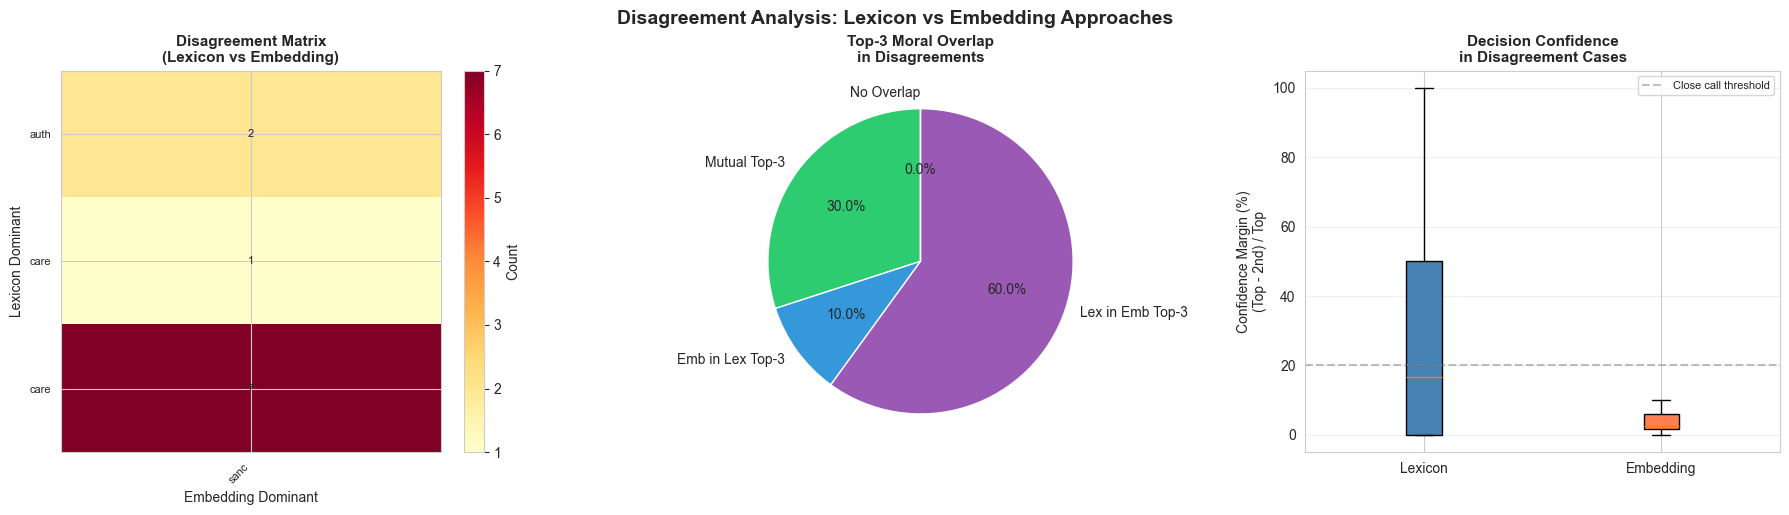


📈 CONFIDENCE MARGIN STATISTICS:
   Lexicon: Mean=28.3%, Median=16.7%, Std=32.5%
   Embedding: Mean=3.7%, Median=2.6%, Std=3.0%


In [44]:
# Visualization: Disagreement patterns
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Heatmap of disagreement categories
if all_disagreements:
    # Count which lexicon moral maps to which embedding moral
    disagreement_matrix = {}
    for analysis in all_disagreements:
        lex = analysis['lex_dominant']
        emb = analysis['emb_dominant']
        if lex and emb:
            key = (lex, emb)
            disagreement_matrix[key] = disagreement_matrix.get(key, 0) + 1
    
    if disagreement_matrix:
        # Get unique morals
        lex_morals = sorted(set(k[0] for k in disagreement_matrix.keys()))
        emb_morals = sorted(set(k[1] for k in disagreement_matrix.keys()))
        
        # Create matrix
        matrix = np.zeros((len(lex_morals), len(emb_morals)))
        for (lex, emb), count in disagreement_matrix.items():
            i = lex_morals.index(lex)
            j = emb_morals.index(emb)
            matrix[i, j] = count
        
        # Plot heatmap
        im = axes[0].imshow(matrix, cmap='YlOrRd', aspect='auto')
        axes[0].set_xticks(range(len(emb_morals)))
        axes[0].set_yticks(range(len(lex_morals)))
        axes[0].set_xticklabels([m.split('.')[0][:4] for m in emb_morals], rotation=45, ha='right', fontsize=8)
        axes[0].set_yticklabels([m.split('.')[0][:4] for m in lex_morals], fontsize=8)
        axes[0].set_xlabel('Embedding Dominant', fontsize=10)
        axes[0].set_ylabel('Lexicon Dominant', fontsize=10)
        axes[0].set_title('Disagreement Matrix\n(Lexicon vs Embedding)', fontsize=11, fontweight='bold')
        
        # Add count labels
        for i in range(len(lex_morals)):
            for j in range(len(emb_morals)):
                if matrix[i, j] > 0:
                    axes[0].text(j, i, int(matrix[i, j]), ha='center', va='center', fontsize=8)
        
        plt.colorbar(im, ax=axes[0], label='Count')
    else:
        axes[0].text(0.5, 0.5, 'No disagreement data', ha='center', va='center', transform=axes[0].transAxes)

# 2. Top 3 overlap analysis
overlap_data = {'Mutual Top-3': pattern_analysis['mutual_top3'],
                'Emb in Lex Top-3': pattern_analysis['emb_in_lex_top3'] - pattern_analysis['mutual_top3'],
                'Lex in Emb Top-3': pattern_analysis['lex_in_emb_top3'] - pattern_analysis['mutual_top3'],
                'No Overlap': pattern_analysis['completely_different']}

colors = ['#2ecc71', '#3498db', '#9b59b6', '#e74c3c']
wedges, texts, autotexts = axes[1].pie(overlap_data.values(), labels=overlap_data.keys(), 
                                        autopct='%1.1f%%', colors=colors, startangle=90)
axes[1].set_title('Top-3 Moral Overlap\nin Disagreements', fontsize=11, fontweight='bold')

# 3. Confidence margin comparison
if all_disagreements:
    lex_margins = []
    emb_margins = []
    
    for analysis in all_disagreements:
        if len(analysis['lex_top3']) >= 2 and analysis['lex_top3'][0][1] > 0:
            margin = (analysis['lex_top3'][0][1] - analysis['lex_top3'][1][1]) / analysis['lex_top3'][0][1] * 100
            lex_margins.append(margin)
        
        if len(analysis['emb_top3']) >= 2 and analysis['emb_top3'][0][1] > 0:
            margin = (analysis['emb_top3'][0][1] - analysis['emb_top3'][1][1]) / analysis['emb_top3'][0][1] * 100
            emb_margins.append(margin)
    
    if lex_margins and emb_margins:
        bp = axes[2].boxplot([lex_margins, emb_margins], labels=['Lexicon', 'Embedding'], patch_artist=True)
        bp['boxes'][0].set_facecolor('steelblue')
        bp['boxes'][1].set_facecolor('coral')
        axes[2].set_ylabel('Confidence Margin (%)\n(Top - 2nd) / Top', fontsize=10)
        axes[2].set_title('Decision Confidence\nin Disagreement Cases', fontsize=11, fontweight='bold')
        axes[2].grid(axis='y', alpha=0.3)
        
        axes[2].axhline(y=20, color='gray', linestyle='--', alpha=0.5, label='Close call threshold')
        axes[2].legend(fontsize=8)

plt.tight_layout()
plt.suptitle('Disagreement Analysis: Lexicon vs Embedding Approaches', fontsize=14, fontweight='bold', y=1.02)
plt.show()

# Print summary statistics
print("\n📈 CONFIDENCE MARGIN STATISTICS:")
if lex_margins:
    print(f"   Lexicon: Mean={np.mean(lex_margins):.1f}%, Median={np.median(lex_margins):.1f}%, Std={np.std(lex_margins):.1f}%")
if emb_margins:
    print(f"   Embedding: Mean={np.mean(emb_margins):.1f}%, Median={np.median(emb_margins):.1f}%, Std={np.std(emb_margins):.1f}%")

In [46]:
# Save detailed disagreement analysis
print("="*70)
print("SAVING DETAILED DISAGREEMENT ANALYSIS")
print("="*70)

# Create detailed disagreement dataframe
disagreement_records = []
for analysis in all_disagreements:
    record = {
        'paragraph_num': analysis['para_num'],
        'text_preview': analysis['text'][:200] + '...' if len(analysis['text']) > 200 else analysis['text'],
        'lexicon_dominant': analysis['lex_dominant'],
        'lexicon_2nd': analysis['lex_top3'][1][0] if len(analysis['lex_top3']) > 1 else None,
        'lexicon_3rd': analysis['lex_top3'][2][0] if len(analysis['lex_top3']) > 2 else None,
        'lexicon_top_score': analysis['lex_top3'][0][1] if analysis['lex_top3'] else 0,
        'embedding_dominant': analysis['emb_dominant'],
        'embedding_2nd': analysis['emb_top3'][1][0] if len(analysis['emb_top3']) > 1 else None,
        'embedding_3rd': analysis['emb_top3'][2][0] if len(analysis['emb_top3']) > 2 else None,
        'embedding_top_score': analysis['emb_top3'][0][1] if analysis['emb_top3'] else 0,
        'mfd_words_found': str(analysis['mfd_matches']) if analysis['mfd_matches'] else 'None'
    }
    disagreement_records.append(record)

disagreement_df = pd.DataFrame(disagreement_records)

# Save to CSV
output_file = 'detailed_disagreement_analysis.csv'
disagreement_df.to_csv(output_file, index=False)
print(f"✓ Saved {output_file}")

# Display sample
print(f"\nSample of disagreement analysis (first 5 rows):")
print(disagreement_df[['paragraph_num', 'lexicon_dominant', 'lexicon_2nd', 'embedding_dominant', 'embedding_2nd']].head())

SAVING DETAILED DISAGREEMENT ANALYSIS
✓ Saved detailed_disagreement_analysis.csv

Sample of disagreement analysis (first 5 rows):
   paragraph_num  lexicon_dominant       lexicon_2nd embedding_dominant  \
0              1  authority.virtue         care.vice    sanctity.virtue   
1              3       care.virtue     sanctity.vice    sanctity.virtue   
2              4       care.virtue  authority.virtue    sanctity.virtue   
3              5       care.virtue  authority.virtue    sanctity.virtue   
4              6  authority.virtue       care.virtue    sanctity.virtue   

      embedding_2nd  
0       care.virtue  
1  authority.virtue  
2  authority.virtue  
3       care.virtue  
4  authority.virtue  


## Debug End

## 6. Aggregate Statistics Across All Texts

In [47]:
# Calculate aggregate statistics
print("="*70)
print("AGGREGATE STATISTICS ACROSS ALL TEXTS")
print("="*70)

total_texts = sum(len(df) for df in lexicon_results.values())
total_with_matches = sum((df['dominant_moral_lexicon'].notna()).sum() for df in lexicon_results.values())
total_coverage = total_with_matches / total_texts * 100

print(f"\nTotal paragraphs analyzed: {total_texts}")
print(f"Paragraphs with lexicon matches: {total_with_matches} ({total_coverage:.1f}%)")
print(f"Paragraphs with no matches: {total_texts - total_with_matches} ({100-total_coverage:.1f}%)")

# Calculate agreement across all comparable texts
all_agreements = []
all_comparisons = 0

for text_name, compare_df in comparison_results.items():
    compare_clean = compare_df.dropna()
    if len(compare_clean) > 0:
        agreements = (compare_clean['dominant_lexicon'] == compare_clean['dominant_embedding']).sum()
        all_agreements.append(agreements)
        all_comparisons += len(compare_clean)

overall_agreement = 0
if all_comparisons > 0:
    overall_agreement = sum(all_agreements) / all_comparisons * 100
    print(f"\nOverall agreement (where both methods scored): {sum(all_agreements)}/{all_comparisons} ({overall_agreement:.1f}%)")

print("\n" + "="*70)

AGGREGATE STATISTICS ACROSS ALL TEXTS

Total paragraphs analyzed: 436
Paragraphs with lexicon matches: 400 (91.7%)
Paragraphs with no matches: 36 (8.3%)

Overall agreement (where both methods scored): 90/400 (22.5%)



## 7. Coverage Analysis by Text

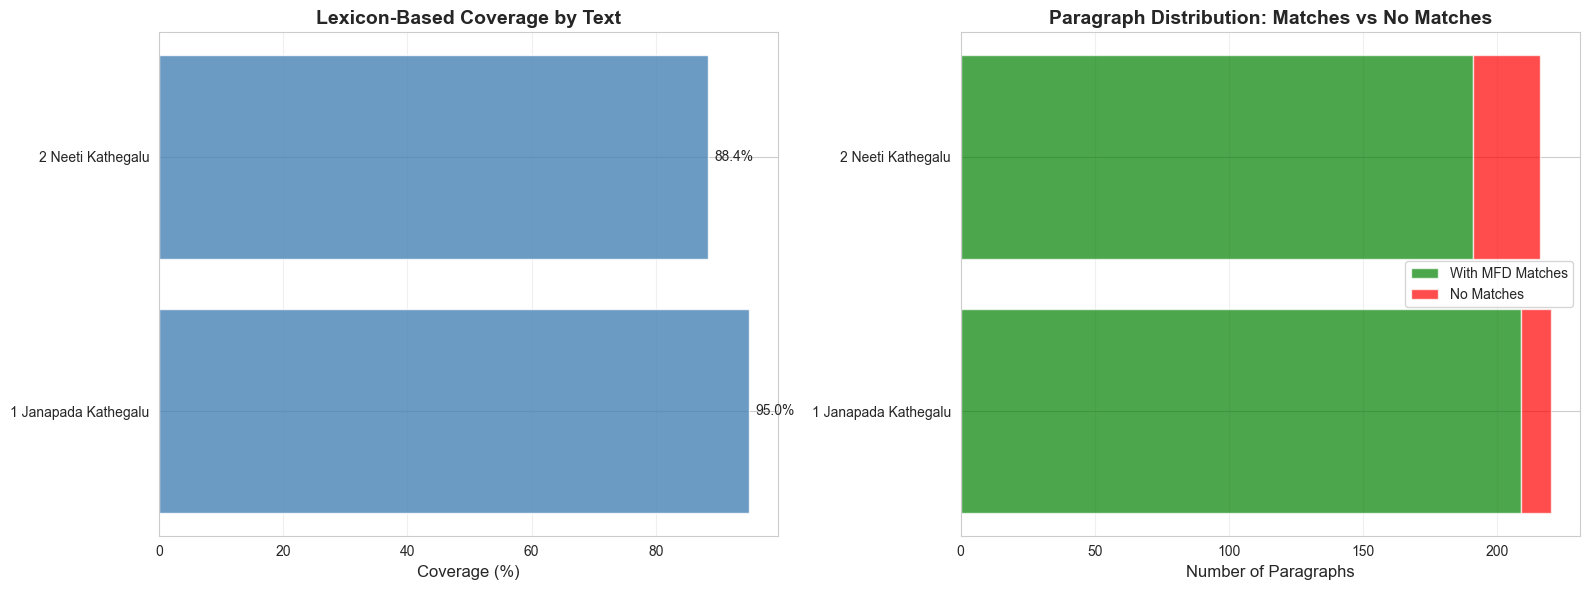


Coverage Summary:
                Text  Total  With Matches  Coverage (%)
1 Janapada Kathegalu    220           209     95.000000
   2 Neeti Kathegalu    216           191     88.425926


In [48]:
# Create coverage comparison chart
coverage_data = []
for text_name, lex_df in lexicon_results.items():
    total = len(lex_df)
    with_matches = lex_df['dominant_moral_lexicon'].notna().sum()
    coverage_pct = with_matches / total * 100
    coverage_data.append({
        'Text': text_name.replace('_', ' ').replace('-', ' ').title(),
        'Total': total,
        'With Matches': with_matches,
        'Coverage (%)': coverage_pct
    })

coverage_df = pd.DataFrame(coverage_data).sort_values('Coverage (%)', ascending=False)

# Plot coverage
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Bar chart
ax1.barh(coverage_df['Text'], coverage_df['Coverage (%)'], color='steelblue', alpha=0.8)
ax1.set_xlabel('Coverage (%)', fontsize=12)
ax1.set_title('Lexicon-Based Coverage by Text', fontsize=14, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)
for i, v in enumerate(coverage_df['Coverage (%)']):
    ax1.text(v + 1, i, f"{v:.1f}%", va='center', fontsize=10)

# Stacked bar chart
texts = coverage_df['Text']
with_matches = coverage_df['With Matches']
without_matches = coverage_df['Total'] - coverage_df['With Matches']

ax2.barh(texts, with_matches, label='With MFD Matches', color='green', alpha=0.7)
ax2.barh(texts, without_matches, left=with_matches, label='No Matches', color='red', alpha=0.7)
ax2.set_xlabel('Number of Paragraphs', fontsize=12)
ax2.set_title('Paragraph Distribution: Matches vs No Matches', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print("\nCoverage Summary:")
print(coverage_df.to_string(index=False))

## 8. Dominant Moral Distribution Comparison

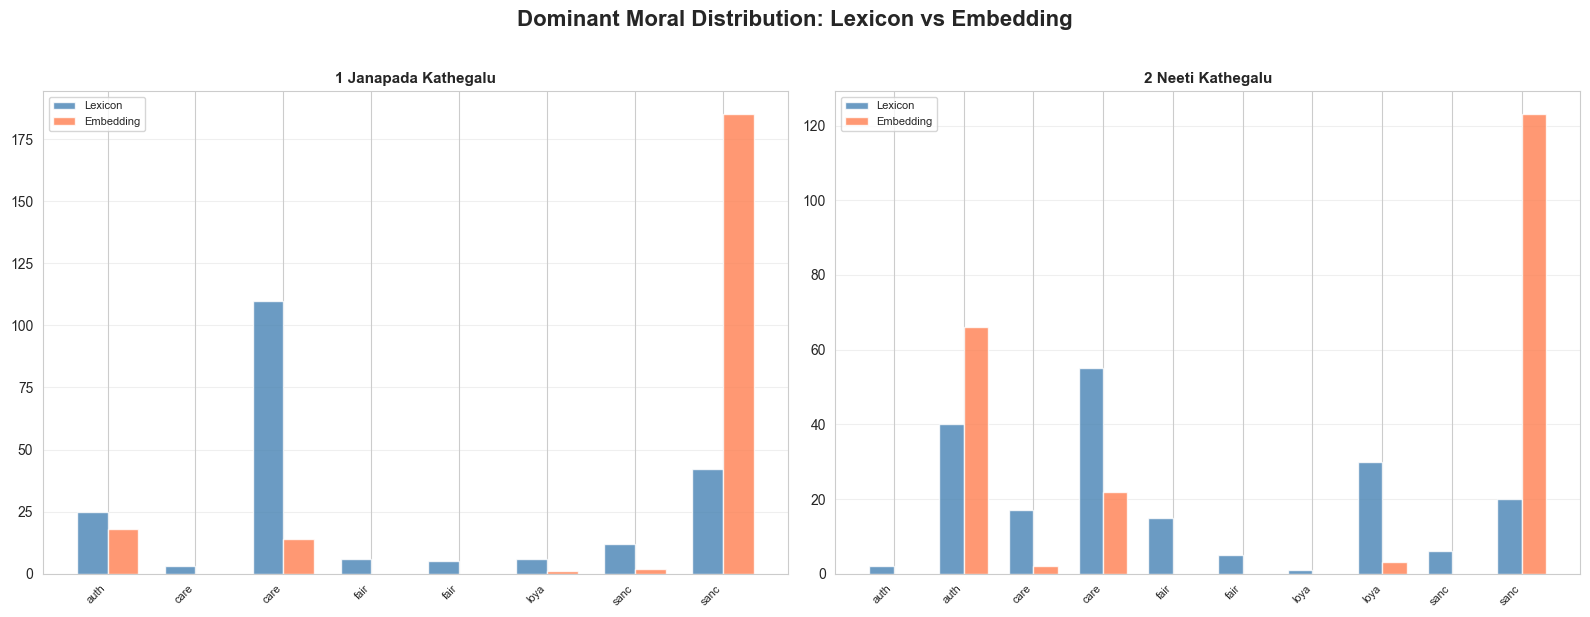

In [49]:
# Compare dominant moral distributions
num_texts = len(comparison_results)
if num_texts > 0:
    fig, axes = plt.subplots(1, num_texts, figsize=(8*num_texts, 6))
    if num_texts == 1:
        axes = [axes]

    for idx, (text_name, compare_df) in enumerate(comparison_results.items()):
        ax = axes[idx]
        
        # Count dominant morals
        lex_counts = compare_df['dominant_lexicon'].value_counts()
        emb_counts = compare_df['dominant_embedding'].value_counts()
        
        # Combine for comparison
        all_morals = set(lex_counts.index.dropna()) | set(emb_counts.index.dropna())
        if len(all_morals) == 0:
            ax.text(0.5, 0.5, 'No data', ha='center', va='center', transform=ax.transAxes)
            ax.set_title(text_name.replace('_', ' ').replace('-', ' ').title(), fontsize=11, fontweight='bold')
            continue
            
        lex_vals = [lex_counts.get(m, 0) for m in sorted(all_morals)]
        emb_vals = [emb_counts.get(m, 0) for m in sorted(all_morals)]
        
        x = np.arange(len(all_morals))
        width = 0.35
        
        ax.bar(x - width/2, lex_vals, width, label='Lexicon', alpha=0.8, color='steelblue')
        ax.bar(x + width/2, emb_vals, width, label='Embedding', alpha=0.8, color='coral')
        
        ax.set_title(text_name.replace('_', ' ').replace('-', ' ').title(), fontsize=11, fontweight='bold')
        ax.set_xticks(x)
        ax.set_xticklabels([m.split('.')[0][:4] for m in sorted(all_morals)], rotation=45, ha='right', fontsize=8)
        ax.legend(fontsize=8)
        ax.grid(axis='y', alpha=0.3)

    plt.suptitle('Dominant Moral Distribution: Lexicon vs Embedding', fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
else:
    print("No comparison data available")

## 9. Summary and Conclusions

In [51]:
print("="*70)
print("SUMMARY: LEXICON-BASED VS EMBEDDING-BASED COMPARISON")
print("ALL KANNADA TEXTS")
print("="*70)

print("\n OVERALL STATISTICS:")
print(f"  - Total paragraphs analyzed: {total_texts}")
print(f"  - Paragraphs with lexicon matches: {total_with_matches} ({total_coverage:.1f}%)")
print(f"  - Overall agreement rate: {overall_agreement:.1f}%" if all_comparisons > 0 else "  - Overall agreement rate: N/A")

print("\nEMBEDDING-BASED ADVANTAGES:")
print("  1. 100% coverage - works on ALL texts")
print("  2. Captures semantic similarity (synonyms, paraphrases)")
print("  3. More nuanced - continuous scores instead of binary")
print("  4. Better for literary texts (poetic language, metaphors)")

print("\nLEXICON-BASED ADVANTAGES:")
print("  1. Fast - no GPU needed")
print("  2. Interpretable - easy to see why a text scores high")
print("  3. Transparent - can trace back to specific words")
print("  4. Simple baseline for comparison")

print("\nKEY FINDINGS:")
print(f"  - Average lexicon coverage: {total_coverage:.1f}%")
print(f"  - {100-total_coverage:.1f}% of paragraphs have NO exact MFD word matches")
print(f"  - Agreement varies significantly across different texts")
print(f"  - Folk tales may show different patterns due to narrative style")

print("\n🎯 RECOMMENDATIONS:")
print("  1. Use EMBEDDING-BASED approach as primary method")
print("  2. Use LEXICON-BASED as validation/interpretability tool")
print("  3. When both agree → high confidence in moral classification")
print("  4. When they disagree → manual inspection recommended")
print("  5. Consider text-specific characteristics when interpreting results")

print("\n📚 TEXTS ANALYZED:")
for text_name, df in texts_data.items():
    coverage = (lexicon_results[text_name]['dominant_moral_lexicon'].notna().sum() / len(df)) * 100
    print(f"  - {text_name.replace('_', ' ').replace('-', ' ').title()}: {len(df)} paragraphs ({coverage:.1f}% coverage)")

print("\n" + "="*70)

SUMMARY: LEXICON-BASED VS EMBEDDING-BASED COMPARISON
ALL KANNADA TEXTS

 OVERALL STATISTICS:
  - Total paragraphs analyzed: 436
  - Paragraphs with lexicon matches: 400 (91.7%)
  - Overall agreement rate: 22.5%

EMBEDDING-BASED ADVANTAGES:
  1. 100% coverage - works on ALL texts
  2. Captures semantic similarity (synonyms, paraphrases)
  3. More nuanced - continuous scores instead of binary
  4. Better for literary texts (poetic language, metaphors)

LEXICON-BASED ADVANTAGES:
  1. Fast - no GPU needed
  2. Interpretable - easy to see why a text scores high
  3. Transparent - can trace back to specific words
  4. Simple baseline for comparison

KEY FINDINGS:
  - Average lexicon coverage: 91.7%
  - 8.3% of paragraphs have NO exact MFD word matches
  - Agreement varies significantly across different texts
  - Folk tales may show different patterns due to narrative style

🎯 RECOMMENDATIONS:
  1. Use EMBEDDING-BASED approach as primary method
  2. Use LEXICON-BASED as validation/interpretab

## 10. Save Results

In [52]:
# Create output directory if it doesn't exist
os.makedirs('lexicon-comparison-results', exist_ok=True)

# Save lexicon results
for text_name, df in lexicon_results.items():
    output_file = f'lexicon-comparison-results/{text_name}_lexicon_scores.csv'
    df.to_csv(output_file, index=False)
    print(f"✓ Saved {output_file}")

# Save comparison results
for text_name, df in comparison_results.items():
    output_file = f'lexicon-comparison-results/{text_name}_method_comparison.csv'
    df.to_csv(output_file, index=False)
    print(f"✓ Saved {output_file}")

# Save aggregate statistics
coverage_df.to_csv('lexicon-comparison-results/coverage_summary.csv', index=False)
print(f"✓ Saved lexicon-comparison-results/coverage_summary.csv")

print("\n✓ All results saved to lexicon-comparison-results/ folder")

✓ Saved lexicon-comparison-results/1-janapada-kathegalu_lexicon_scores.csv
✓ Saved lexicon-comparison-results/2-neeti-kathegalu_lexicon_scores.csv
✓ Saved lexicon-comparison-results/1-janapada-kathegalu_method_comparison.csv
✓ Saved lexicon-comparison-results/2-neeti-kathegalu_method_comparison.csv
✓ Saved lexicon-comparison-results/coverage_summary.csv

✓ All results saved to lexicon-comparison-results/ folder


### Human Annotation Evaluation

- Select 10 random paragraphs 
- Ask human to rank top 3 morals they think is prevalent
- Compare with results from phase3_outputs/ moral scores
